In [1]:

import torch
from torchvision.transforms import InterpolationMode
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from skimage.transform import resize as resize_im
import pytorch_lightning as pl
import numpy as np
import sys
from tqdm import tqdm
from PIL import Image, ImageOps

sys.path.append("../src")

from lightning.data import PlaceRecognitionDataModule
from models.networks.imageretrievalnet import init_network
from datasets.aerialstreet import TestDataset
from utils.evaluate import recall, mapk
from utils.evaluate import MeanAveragePrecision

In [2]:
model_params = {}
model_params['architecture'] = 'resnet50'
model_params['pooling'] = 'gem'
model_params['whitening'] = False
model_params['pretrained'] = True

model = init_network(model_params)

model_path = "../src/lightning_logs/resnet50/05-07_08-40-52_checkpoints/last.ckpt"

checkpoint = torch.load(model_path)
statedict = {}
for key in checkpoint["state_dict"].keys():
    statedict[key.replace("model.","")] = checkpoint["state_dict"][key]

model.load_state_dict(statedict)
model = model.to("cuda:0")

>> imageretrievalnet.py: for 'resnet50' custom pretrained features 'imagenet-caffe-resnet50-features-ac468af.pth' are used


In [3]:
# Data loading code
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])

resize = transforms.Resize((480, 640), interpolation=InterpolationMode.BICUBIC)

transform = transforms.Compose([
    resize,
    transforms.ToTensor(),
    normalize,
        ])

dataset = TestDataset(
    name='aerial_street_dataset',
    mode='test',
    imsize=640,
    transform=transform,
    posDistThr=25,
    negDistThr=25, 
    root_dir = "/home/frwa/Desktop/data/aerial_street_dataset",
)

dataloader = DataLoader(
            dataset, batch_size=16, shuffle=False,
            num_workers=4, pin_memory=True, drop_last=False
        )

In [4]:
metric = MeanAveragePrecision(25)
metric.reset()

In [5]:
model.eval()
for batch in tqdm(dataloader):

    x, index, utm = batch

    x = x.to("cuda:0")
    with torch.no_grad():
        output = model(x)

    metric.update(output["global_embed"], index, utm)

    

100%|██████████| 193/193 [00:31<00:00,  6.22it/s]


In [6]:

metric.q_embed = torch.cat(metric.q_embed)
metric.db_embed = torch.cat(metric.db_embed)
metric.utmQ = torch.cat(metric.utmQ)
metric.utmDb = torch.cat(metric.utmDb)
metric.q_index = torch.cat(metric.q_index)
metric.db_index = torch.cat(metric.db_index)

ranks, pidxs = metric.rank()

In [7]:
mAPs = [mapk(ranks, pidxs, k = k) for k in [5, 10, 20]]
recalls = recall(ranks, pidxs, ks= [1, 5, 10, 20])

for i, k in enumerate([5, 10, 20]):
    print("val_map/map@{}".format(k), mAPs[i])

for i, k in enumerate([1, 5, 10, 20]):
    print("val_recall/recall@{}".format(k), recalls[i])

val_map/map@5 0.5140350877192983
val_map/map@10 0.4706746031746032
val_map/map@20 0.4292323020207573
val_recall/recall@1 0.6105263157894737
val_recall/recall@5 0.8631578947368421
val_recall/recall@10 0.9368421052631579
val_recall/recall@20 0.968421052631579


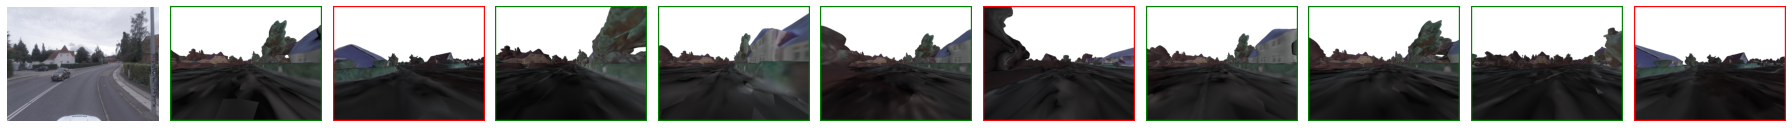

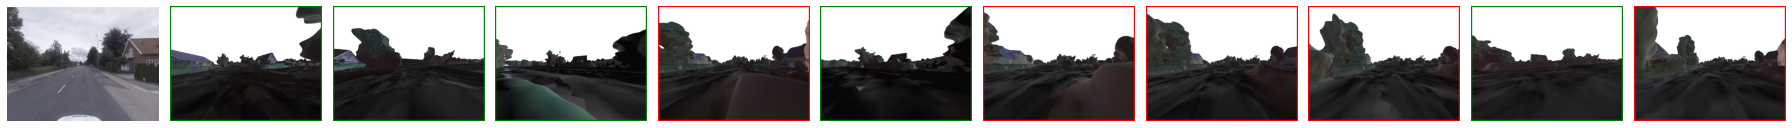

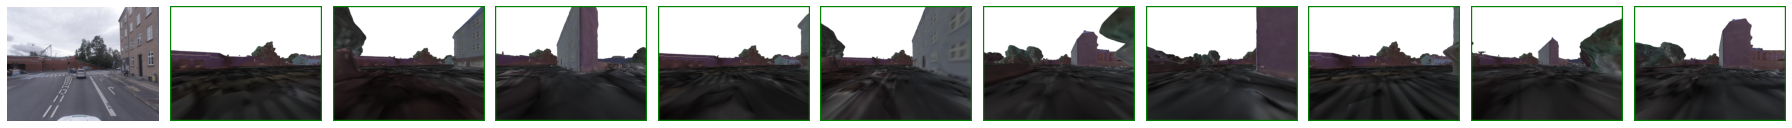

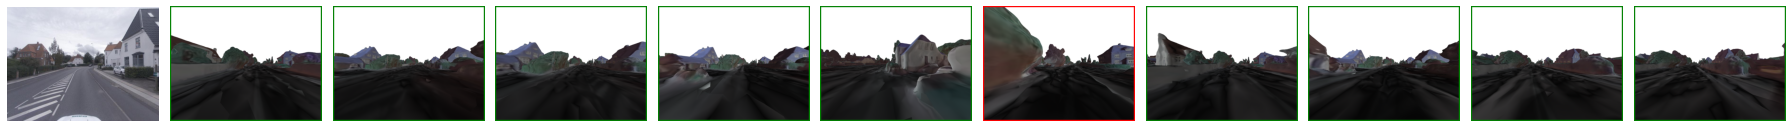

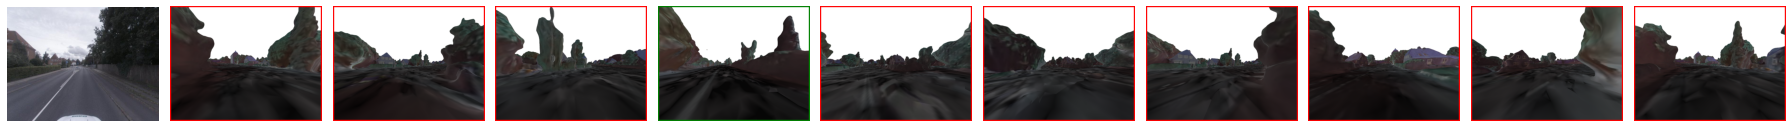

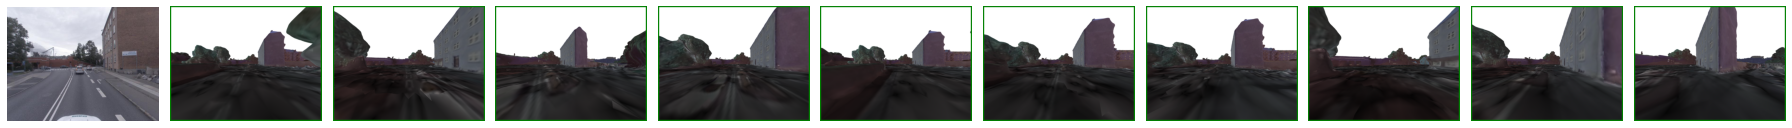

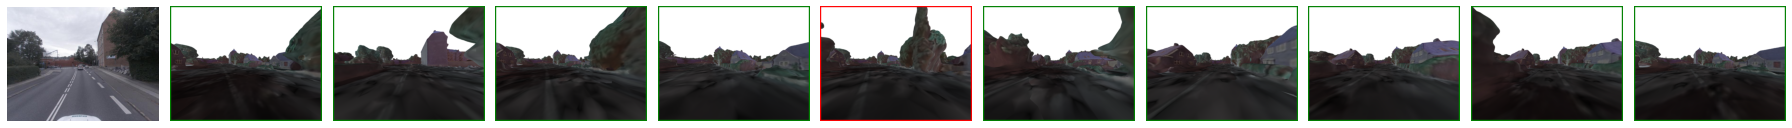

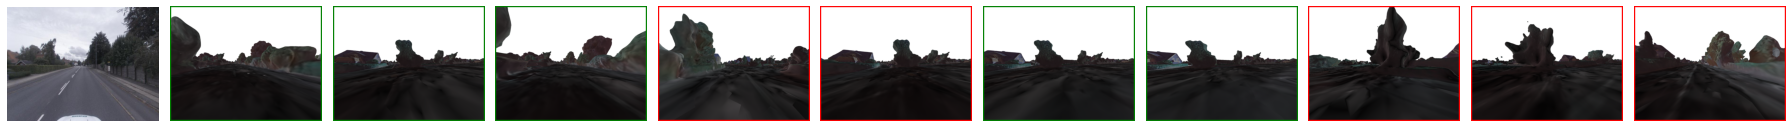

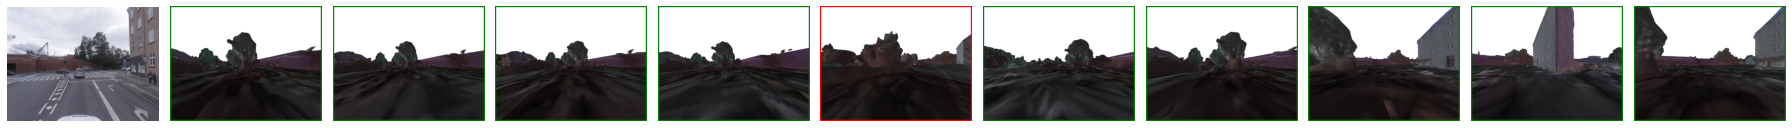

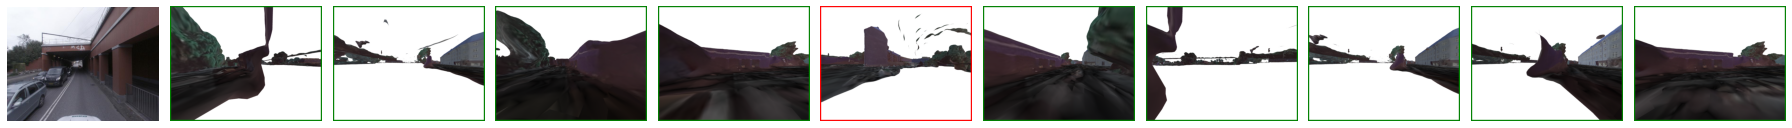

In [8]:
k = 10
for i in np.random.randint(0,ranks.shape[0], 10):
    topk = ranks[i, :k]

    qim = dataset.qImages[dataset.qidxs[i]]
    qim = Image.open(qim)

    plt.figure(figsize=(25,5))
    plt.subplot(1,k+1,1)
    plt.imshow(qim)
    plt.axis('off')

    for j in range(k):

        dbim = dataset.dbImages[topk[j]]
        c = 'green' if topk[j] in pidxs[i] else 'red' 
        dbim = ImageOps.expand(Image.open(dbim), border=5, fill=c)
    
        plt.subplot(1,k+1,2+j)
        plt.imshow(dbim)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

